# Определение возраста покупателей


Построить модель, которая по фотографии определит приблизительный возраст человека. Есть набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

### Импорт данных

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


### Анализ возрастов

In [4]:
display(labels.head())
display(labels.describe())
print('Количество дубликатов:', labels.duplicated().sum(), '\n\nInfo:')
labels.info()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


Количество дубликатов: 0 

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Text(0, 0.5, 'Количество примеров')

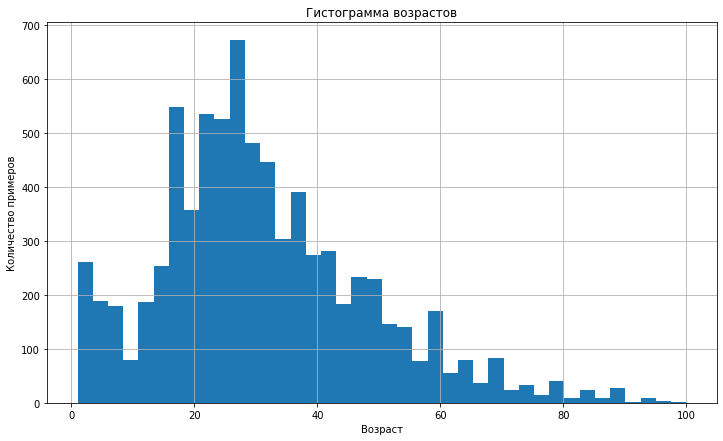

In [5]:
labels.hist(column='real_age', bins=40, figsize=(12, 7))
plt.title('Гистограмма возрастов')
plt.xlabel('Возраст')
plt.ylabel('Количество примеров')

* Всего в выборке представленно 7591 записей с фотографией и реальным возрастом человека;
* Пропусков и дубликатов в выборке нет;
* Типы данных назначены правильные;
* Средний возраст = 31, медианный 29;
* Среднее больше медианы - выборка смещена влево, как видно на гистограмме, с пологим праввым плечом;
* 25% людей в выборке - дети и подростки;
* 50% выборки приходится на людей в возрасте от 20 до 41 года;
* 75% людей в выборке моложе 41 года - в основном представлены молодые люди;
* Минимальный возраст равен 1, максимальный 100.

In [5]:
ages = labels['real_age'].unique()

In [6]:
no_ages = []
for i in range(ages.min(), ages.max()+1):
    if i not in ages:
        no_ages.append(i)

print(f'Минимальный возраст: {ages.min()};\nМаксимальный возраст: {ages.max()}.')
print('Для этих возрастов нет примеров:', no_ages)

Минимальный возраст: 1;
Максимальный возраст: 100.
Для этих возрастов нет примеров: [92, 98, 99]


В выборке представлены все возрасте от 1 года до 100 лет, за исключением следующих возрастов: 92, 98, 99.

In [7]:
images = next(train_gen_flow)

Под индексом *0* в картеже находится пакет с 32 фотографиями размером 224x224x3.

In [8]:
images[0].shape

(32, 224, 224, 3)

Под индексом *1* в картеже находится массив с целевым признаком для каждой из 32 фотографий.

In [9]:
images[1]

array([50, 41, 46, 85, 14, 40, 14, 53,  4, 32, 14, 23, 37, 62, 21, 58, 43,
       32, 25, 94, 30, 16, 23, 18, 41, 24, 26, 14, 36, 28, 78, 13])

Далее распечатаны первые 15 фотографий из первого пакета с указанием реального возраста в углу.

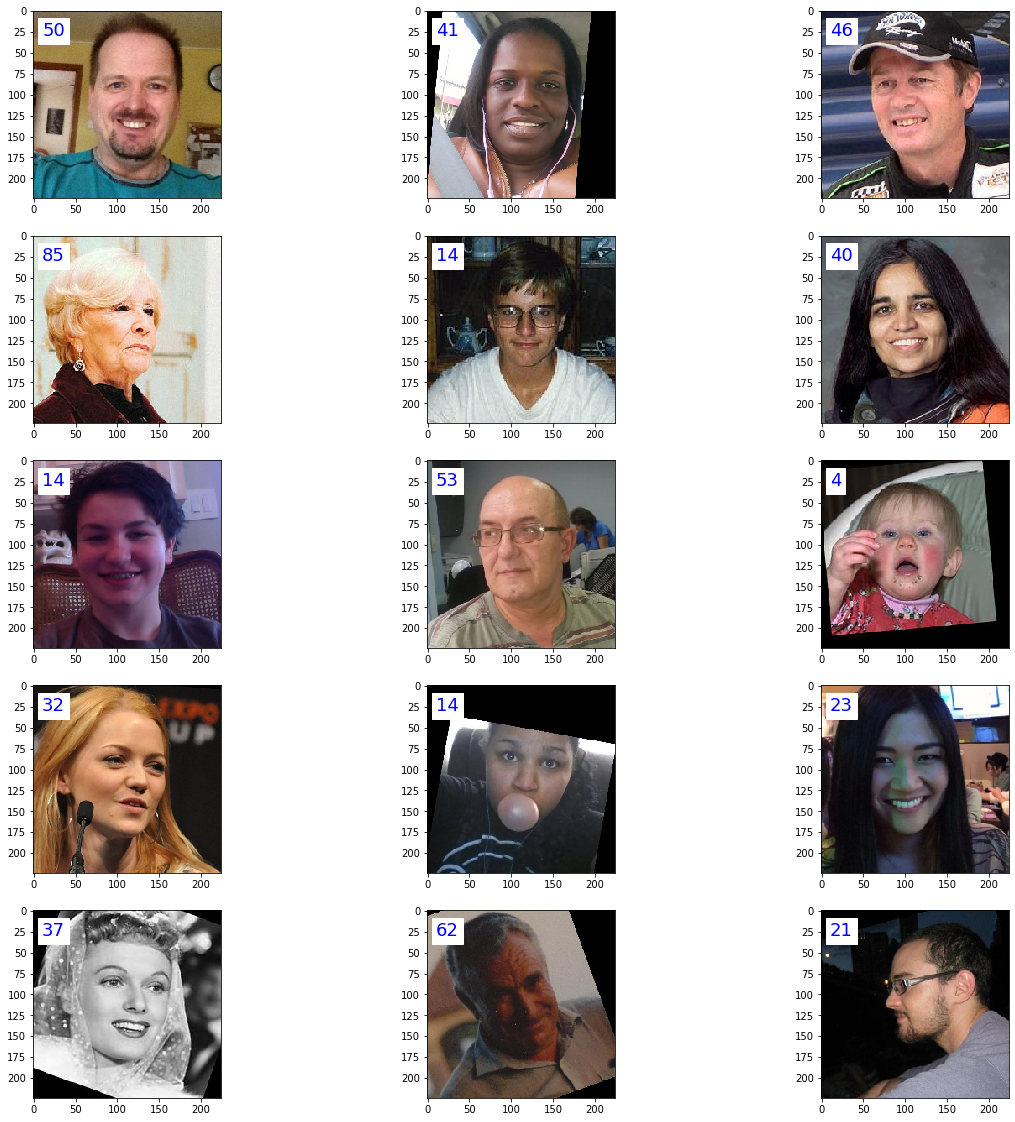

In [10]:
fig, ax = plt.subplots(nrows = 5, ncols=3, figsize=(20,20))
for i in range(5):
    for j in range(3):
        ax[i, j].imshow(images[0][i*3+j])
        ax[i, j].text(10, 30, images[1][i*3+j], color='blue', size=18, backgroundcolor='white')

### Вывод

В датасете значительно больше примеров для молодых людей => 
* Точность определения возраста молодых людей будет выше;
* Модель будет склонна предсказывать для пожилых людей возраст меньше, чем тот, которым они реально обладают.

Это можно исправить, создав больше искусственных примеров для людей с возрастом >= 60.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

import pandas as pd
import numpy as np

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50


def load_train(path):
    labels = pd.read_csv(path+'labels.csv')
    train_datagen = ImageDataGenerator(rescale=1. / 255,
                                       validation_split=0.2,
                                       horizontal_flip=True);
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path+'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345);
    return train_datagen_flow


def load_test(path):
    labels = pd.read_csv(path+'labels.csv')
    test_datagen = ImageDataGenerator(rescale=1. / 255,
                                      validation_split=0.2)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path+'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)
    return test_datagen_flow


def create_model(input_shape):
    optimizer = Adam(lr=0.0001)
    backbone = ResNet50(input_shape=input_shape,
                         weights='imagenet',
                         include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])
    return model


def train_model(model, train_data, test_data, steps_per_epoch=None, validation_steps=None, epochs=10):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model

```

```

<class 'tensorflow.python.keras.engine.sequential.Sequential'>
Train for 190 steps, validate for 48 steps
Epoch 1/10
190/190 - 44s - loss: 230.4601 - mae: 10.8720 - val_loss: 813.6731 - val_mae: 23.4811
Epoch 2/10
190/190 - 37s - loss: 73.0711 - mae: 6.4771 - val_loss: 747.4600 - val_mae: 22.1993
Epoch 3/10
190/190 - 37s - loss: 50.4078 - mae: 5.3905 - val_loss: 192.2198 - val_mae: 10.1281
Epoch 4/10
190/190 - 37s - loss: 35.2609 - mae: 4.5047 - val_loss: 97.0282 - val_mae: 7.4913
Epoch 5/10
190/190 - 37s - loss: 27.9495 - mae: 4.0303 - val_loss: 75.3270 - val_mae: 6.6011
Epoch 6/10
190/190 - 37s - loss: 21.7728 - mae: 3.5963 - val_loss: 75.4576 - val_mae: 6.4382
Epoch 7/10
190/190 - 37s - loss: 17.7786 - mae: 3.2221 - val_loss: 79.3286 - val_mae: 6.8814
Epoch 8/10
190/190 - 37s - loss: 14.5493 - mae: 2.9222 - val_loss: 67.1646 - val_mae: 6.1005
Epoch 9/10
190/190 - 37s - loss: 12.1388 - mae: 2.6784 - val_loss: 67.1131 - val_mae: 6.0338
Epoch 10/10
190/190 - 38s - loss: 11.2093 - mae: 2.5332 - val_loss: 64.7149 - val_mae: 5.9891


```

## Анализ обученной модели

Простой *Transfer learning & fine-tuning* позволил добиться малого значения среднего абсолютного отклонения на тестовой выборке. 

Модель получилась слегка переобученной, что в данном случае можно считать приемлемым.
Архитектура **ResNet50** с предобученными весами на датасете *ImageNet* хорошо показала себя в данной задаче: финальное значение метрики *mae* на тестовой выборке = 5.99.

Улучшить модель и уменьшить эффект переобучения можно попробовав использовать слои прореживания *Dropout*, регуляризацию в слоях, тестом других архитектур и весов - например, используя веса от модели, которая обучалась на датасетах лиц IMDB и Wikipedia.

Полученное *mae* позволяет определить достаточно узкую возрастную группу людей для рекомендации специфических товаров, а также выступить как одним из факторов контроля по продаже товаров, не предзначенных для несовершеннолетних. 